In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import metrics
from sklearn.preprocessing import scale

# 유방암 데이터 의사 결정 나무 (GridSearchCV)

## 데이터 정제

### 데이터 가져오기

In [4]:
data = pd.read_csv("./유방암.csv", engine='python')
data.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 데이터 수정하기

In [7]:
table = str.maketrans(' ', '_')
rename_dict = { col:col.lower().translate(table)  for col in data.columns}

data.rename(columns=rename_dict,inplace=True)
data.columns

Index(['diagnosis', 'mean_radius', 'mean_texture', 'mean_perimeter',
       'mean_area', 'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension'],
      dtype='object')

In [8]:
data_dia_0 = data[data.diagnosis == 0]
data_dia_1 = data[data.diagnosis == 1]
print(data_dia_0.shape,data_dia_1.shape)

(212, 31)

## 이상치 제거

In [10]:
def remove_outlier(data):
    Q1 = data.quantile (0.25) 
    Q3 = data.quantile (0.75) 
    IQR = Q3-Q1
    
    return(data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)])

In [11]:
data_dia_0 = remove_outlier(data_dia_0)
data_dia_1 = remove_outlier(data_dia_1)
print(data_dia_0.shape,data_dia_1.shape)

(151, 31) (254, 31)


In [12]:
data = pd.concat([data_dia_0,data_dia_1])
data_y = data.diagnosis.reset_index().drop('index',axis=1)
# data_y
data_x = data.drop('diagnosis',axis=1)
data_n_2 = pd.DataFrame(scale(data_x),columns=data_x.columns)
# # pd.concat([data_y,data_n_2],axis=1).head()
data_x = pd.concat([data_y,data_n_2],axis=1)
data_x_plot = pd.melt(data_x,id_vars="diagnosis", var_name="features", value_name='value')

In [13]:
np.random.seed(seed=1234)
msk = np.random.rand(data.shape[0],) < 0.7
train = data[msk]
test = data[~msk]

# 의사 결정 나무

##### GridSearchCV를 이용한 최적의 모델 선택

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {"criterion":['gini',"entropy"],
              "max_depth":[i for i in range(1,11)],
              'min_samples_leaf':[i for i in range(1,6)]}
model= DecisionTreeClassifier()

clf = GridSearchCV(model,param_grid,scoring="accuracy")
clf.fit(train.drop("diagnosis",axis=1),train.diagnosis)


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

## 결과 확인

In [28]:
clf.cv_results_["params"][-5:]

[{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1},
 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2},
 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3},
 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4},
 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}]

In [29]:
clf.cv_results_["mean_test_score"][-5:]

array([0.93382353, 0.91911765, 0.95220588, 0.9375    , 0.93014706])

##### 최고 득점  모델의 Criterion: gini, Max_depth: 8, Min_samples_leaf: 3 선택

In [33]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3}

In [34]:
clf.best_score_

0.9522058823529411

### 선택된 모델을 이용한 결과 예측

In [32]:
clf.score(test.drop("diagnosis",axis=1),test.diagnosis)

0.924812030075188

##### 정확도 92.5%

# 트리 모양 확인

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


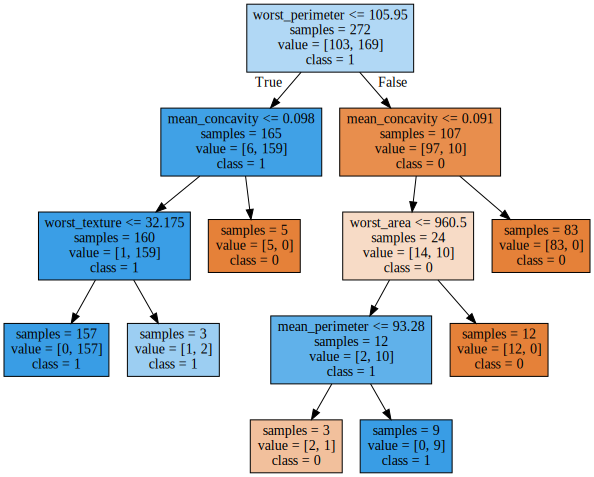

In [35]:
from sklearn.tree import export_graphviz
import graphviz

clf.fit(train.drop("diagnosis",axis=1),train.diagnosis)

export_graphviz(clf.best_estimator_,out_file="clf.dot", class_names=['0','1'], feature_names=data.drop("diagnosis",axis=1).columns,impurity=False, filled=True)

with open("clf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))